In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report

In [2]:
def preprocess(df):
  df = df.drop(columns=['Unnamed: 0','run_id','branch','run_timestamp','stage_timestamp','stage_duration','test_suite_duration','stage_id','avg_duration','authors_distinct_len','file_ext_distinct_len','min_filepath_distance_lv','max_filepath_token_similarity','min_filename_distance_lv','max_freq','max_failure_freq','max_failure_freq_rel','last_test_suite_duration','max_freq_rel','commits_len'])
  # test_ids = df['test_identifier'].unique()
  df = df.drop(columns=['test_identifier'])
  #add VCS
  df['lines_inserted'] = np.random.randint(0, 2000, size=len(df))
  df['lines_deleted'] = np.random.randint(0, 2000, size=len(df))

  #sanitize boolean values
  df['has_transitioned'] = df['has_transitioned'].astype(int)
  df['has_failed'] = df['has_failed'].astype(int)
  X = df.drop(columns=['has_failed'])
  y = df['has_failed']
  return X,y

In [3]:
def build_fault_matrix(df):
    fault_counter = 0
    test_fault_map = {}
    for _, row in df.iterrows():
        test = row['test_identifier']
        failed = row['has_failed']
        if failed and test not in test_fault_map:
            fault_counter += 1
            fault_id = f'F{fault_counter}'
            test_fault_map[test] = fault_id  # doar un fault per test

    # Matrice test × fault (binary)
    unique_tests = sorted(df['test_identifier'].unique())
    unique_faults = sorted(set(test_fault_map.values()))

    matrix = pd.DataFrame(0, index=unique_tests, columns=unique_faults)

    for test, fault in test_fault_map.items():
        matrix.loc[test, fault] = 1

    return matrix

In [4]:
def calculate_apfd(fault_matrix, ordered_test_list):
    """
    Calculează APFD pentru o suită de teste ordonată.
    :param fault_matrix: matricea test vs fault (0/1)
    :param ordered_test_list: listă de test_identifiers în ordinea execuției
    """
    m = fault_matrix.shape[1]  # număr de faults
    n = fault_matrix.shape[0]  # număr de teste
    tf_sum = 0

    for fault in fault_matrix.columns:
        for idx, test in enumerate(ordered_test_list, start=1):  # 1-based index
            if fault_matrix.loc[test, fault] == 1:
                tf_sum += idx
                break

    apfd = 1 - (tf_sum / (n * m)) + (1 / (2 * n))
    return apfd

In [ ]:
def transboost(df_source,df_target):
    X_source,y_source = preprocess(df_source)

    X_target,y_target = preprocess(df_target)
    X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X_target, y_target, test_size=0.20, random_state=42,stratify=y_target) #Train + test&val; stratify - ensures class balance between test set & train set

    df_test_only = df_target.iloc[X_test_target.index]

    fault_matrix = build_fault_matrix(df_test_only)

    X_domain = np.vstack([X_source, X_train_target])
    # Label source data as 0 and target data as 1
    y_domain = np.hstack([np.zeros(len(X_source)), np.ones(len(X_train_target))])

    #XGBoost classifier to classify whether data is source/target like
    domain_classifier = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
    domain_classifier.fit(X_domain, y_domain)

    # Predict probabilities for source data
    source_weights = domain_classifier.predict_proba(X_source)[:, 1]  # Probability of being target-like

    # Normalize weights
    source_weights = source_weights / np.max(source_weights)

    # Step 2: Train XGBoost on Source Data with Weights
    xgb_transboost = xgb.XGBClassifier(n_estimators=40, learning_rate=0.1, max_depth=4, random_state=42)
    xgb_transboost.fit(X_source, y_source, sample_weight=source_weights)

    # Step 3: Fine-Tune on Target Dataset
    xgb_transboost.fit(X_train_target, y_train_target, xgb_model=xgb_transboost.get_booster())

    # Step 4: Evaluate on Target Test Set
    failure_probs = xgb_transboost.predict_proba(X_test_target)[:, 1]
    results = pd.DataFrame({
        'test_identifier' : df_test_only.loc[X_test_target.index, 'test_identifier'],
        'failure_probability': failure_probs * 100
    })
    # shuffle this unique unordered list
    unorderedList = df_test_only.loc[X_test_target.index, 'test_identifier'].unique().tolist()
    random.seed(42)  # For reproducibility
    random.shuffle(unorderedList)

    results = results.sort_values(by='failure_probability',ascending=False)
    ordered_test_list_final = results['test_identifier'].unique().tolist()

    apfd_unordered = calculate_apfd(fault_matrix,unorderedList)
    apfd_transboost = calculate_apfd(fault_matrix,ordered_test_list_final)
    return apfd_unordered,apfd_transboost

## Training XGBoost on every source project and evaluating MEAN APFD on other projects

In [ ]:
def get_apfd(model,df_target):
    
    X_target,y_target = preprocess(df_target)
    X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X_target, y_target, test_size=0.20, random_state=42,stratify=y_target) #Train + test&val; stratify - ensures class balance between test set & train set

    df_test_only = df_target.iloc[X_test_target.index]
    fault_matrix = build_fault_matrix(df_test_only)
    
    failure_probs = model.predict_proba(X_test_target)[:, 1]
    results = pd.DataFrame({
        'test_identifier' : df_test_only.loc[X_test_target.index, 'test_identifier'],
        'failure_probability': failure_probs * 100
    })
    
    results = results.sort_values(by='failure_probability',ascending=False)
    ordered_test_list_final = results['test_identifier'].unique().tolist()
    apfd_boost = calculate_apfd(fault_matrix,ordered_test_list_final)
    return apfd_boost

In [7]:
def train_xgboost_model(df_source):
    X_source,y_source = preprocess(df_source)
    X_train_source, X_test_source, y_train_source, y_test_source = train_test_split(X_source, y_source, test_size=0.20, random_state=42,stratify=y_source)
    random.seed(42)  # For reproducibility
    model = xgb.XGBClassifier(n_estimators=40, learning_rate=0.1, max_depth=4, random_state=42)
    model.fit(X_train_source, y_train_source)
    return model

In [ ]:
def train_linear_classifier_model(df_source):
    X_source,y_source = preprocess(df_source)
    X_train_source, X_test_source, y_train_source, y_test_source = train_test_split(X_source, y_source, test_size=0.20, random_state=42,stratify=y_source)
    random.seed(42)  # For reproducibility
    model = LogisticRegression(random_state=42, max_iter=500)
    model.fit(X_train_source, y_train_source)
    return model

In [32]:
def save_classification_report(model,df_target,dirTarget):
    
    X_target,y_target = preprocess(df_target)
    _, X_test_target, _, y_test_target = train_test_split(X_target, y_target, test_size=0.20, random_state=42,stratify=y_target) #Train + test&val; stratify - ensures class balance between test set & train set
    y_pred = model.predict(X_test_target)
    report = classification_report(y_test_target, y_pred, output_dict=True,zero_division=0)
    print(f"Report for {dirTarget}",report)
    print("------------------------------------------------")
    

In [34]:
directory = "data"
model = pickle.load(open("models/xgb_model_l0rdn1kk0n@wicket-bootstrap.pkl", "rb"))
for dirTarget in os.listdir(directory):
    df_target = pd.read_csv(f"{directory}/{dirTarget}/MLDataSet.csv")
    save_classification_report(model,df_target,dirTarget)
    

Report for adamfisk@LittleProxy {'0': {'precision': 0.9967562557924003, 'recall': 0.9930747922437673, 'f1-score': 0.9949121184088807, 'support': 2166.0}, '1': {'precision': 0.6428571428571429, 'recall': 0.7941176470588235, 'f1-score': 0.7105263157894737, 'support': 34.0}, 'accuracy': 0.99, 'macro avg': {'precision': 0.8198066993247717, 'recall': 0.8935962196512954, 'f1-score': 0.8527192170991772, 'support': 2200.0}, 'weighted avg': {'precision': 0.991286905865219, 'recall': 0.99, 'f1-score': 0.9905170650956717, 'support': 2200.0}}
------------------------------------------------
Report for apache@sling {'0': {'precision': 0.9992881895663576, 'recall': 0.9992694713969955, 'f1-score': 0.9992788303940209, 'support': 53386.0}, '1': {'precision': 0.8326180257510729, 'recall': 0.8362068965517241, 'f1-score': 0.8344086021505376, 'support': 232.0}, 'accuracy': 0.998563915103137, 'macro avg': {'precision': 0.9159531076587153, 'recall': 0.9177381839743598, 'f1-score': 0.9168437162722792, 'suppor

In [9]:
def train_MLP_model(df_source):
    X_source,y_source = preprocess(df_source)
    X_train_source, X_test_source, y_train_source, y_test_source = train_test_split(X_source, y_source, test_size=0.20, random_state=42,stratify=y_source)
    random.seed(42)  # For reproducibility
    model = MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=100, random_state=42)
    model.fit(X_train_source, y_train_source)
    return model

Transboost

In [14]:
apfd_dict = {}
num_projects = 4
directory = "data"
best_source_project = None
best_mean_apfd = -1
for dirSource in os.listdir(directory):
    mean_apfd = 0
    for dirTarget in os.listdir(directory):
        if dirSource != dirTarget:
            df_source = pd.read_csv(f"{directory}/{dirSource}/MLDataSet.csv")
            df_target = pd.read_csv(f"{directory}/{dirTarget}/MLDataSet.csv")
            _,apfd_ordered = transboost(df_source,df_target)
            mean_apfd+=apfd_ordered
            print(f'Ordered APFD score: for source: {dirSource} and target: {dirTarget} is: {apfd_ordered:.2f}')
    mean_apfd /= num_projects
    if mean_apfd > best_mean_apfd:
        best_mean_apfd = mean_apfd
        best_source_project = dirSource
    apfd_dict[dirSource] = mean_apfd

print(apfd_dict)

print(f"Best source project: {best_source_project} with mean APFD: {best_mean_apfd:.2f}")

Ordered APFD score: for source: adamfisk@LittleProxy and target: apache@sling is: 0.96
Ordered APFD score: for source: adamfisk@LittleProxy and target: DSpace@DSpace is: 0.76
Ordered APFD score: for source: adamfisk@LittleProxy and target: l0rdn1kk0n@wicket-bootstrap is: 0.78
Ordered APFD score: for source: adamfisk@LittleProxy and target: SonarSource@sonarqube is: 0.94
Ordered APFD score: for source: apache@sling and target: adamfisk@LittleProxy is: 0.85
Ordered APFD score: for source: apache@sling and target: DSpace@DSpace is: 0.76
Ordered APFD score: for source: apache@sling and target: l0rdn1kk0n@wicket-bootstrap is: 0.78
Ordered APFD score: for source: apache@sling and target: SonarSource@sonarqube is: 0.96
Ordered APFD score: for source: DSpace@DSpace and target: adamfisk@LittleProxy is: 0.87
Ordered APFD score: for source: DSpace@DSpace and target: apache@sling is: 0.96
Ordered APFD score: for source: DSpace@DSpace and target: l0rdn1kk0n@wicket-bootstrap is: 0.78
Ordered APFD sc

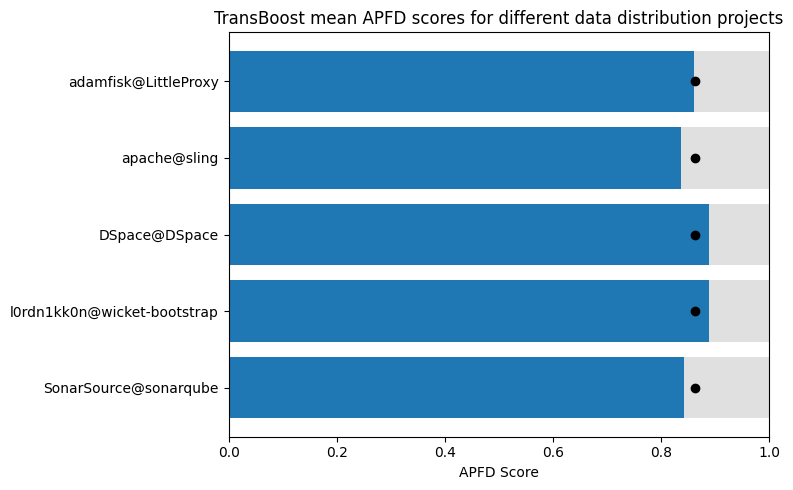

In [41]:
transboost_dict = {'adamfisk@LittleProxy': 0.8609966857495324, 'apache@sling': 0.8370107889496123, 'DSpace@DSpace': 0.8887518772900886, 'l0rdn1kk0n@wicket-bootstrap': 0.8885548842390482, 'SonarSource@sonarqube': 0.8422286284732274}

# Media pentru referință
avg = sum(transboost_dict.values()) / len(transboost_dict)

# Pregătire date
projects = list(transboost_dict.keys())
scores = list(transboost_dict.values())
y_pos = range(len(projects))

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for i, (score, label) in enumerate(zip(scores, projects)):
    ax.barh(i, 1.0, color="#e0e0e0")  # Fundal
    ax.barh(i, score, color="tab:blue")  # Scor
    ax.plot([avg], [i], "ko")  # Media globală

ax.set_yticks(y_pos)
ax.set_yticklabels(projects)
ax.set_xlim(0, 1)
ax.set_xlabel("APFD Score")
ax.set_title("TransBoost mean APFD scores for different data distribution projects")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Linear/MLP/XGBoost

In [13]:
apfd_dict = {}
num_projects = 4
directory = "data"
best_xgb_model = xgb.XGBClassifier()
best_source_project = None
best_mean_apfd = -1
for dirSource in os.listdir(directory):
    mean_apfd = 0
    df_source = pd.read_csv(f"{directory}/{dirSource}/MLDataSet.csv")
    model = train_xgboost_model(df_source)
    for dirTarget in os.listdir(directory):
        if dirSource != dirTarget:
            df_target = pd.read_csv(f"{directory}/{dirTarget}/MLDataSet.csv")
            apfd_ordered = get_apfd(model, df_target)
            mean_apfd+=apfd_ordered
            print(f'Ordered APFD score: for source: {dirSource} and target: {dirTarget} is: {apfd_ordered:.2f}')
    mean_apfd /= num_projects
    if mean_apfd > best_mean_apfd:
        best_mean_apfd = mean_apfd
        best_xgb_model = model
        best_source_project = dirSource
    apfd_dict[dirSource] = mean_apfd

print(apfd_dict)

# Save model
with open(f'models/xgb_model_{best_source_project}.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

Ordered APFD score: for source: adamfisk@LittleProxy and target: apache@sling is: 0.95
Ordered APFD score: for source: adamfisk@LittleProxy and target: DSpace@DSpace is: 0.76
Ordered APFD score: for source: adamfisk@LittleProxy and target: l0rdn1kk0n@wicket-bootstrap is: 0.78
Ordered APFD score: for source: adamfisk@LittleProxy and target: SonarSource@sonarqube is: 0.91
Ordered APFD score: for source: apache@sling and target: adamfisk@LittleProxy is: 0.87
Ordered APFD score: for source: apache@sling and target: DSpace@DSpace is: 0.76
Ordered APFD score: for source: apache@sling and target: l0rdn1kk0n@wicket-bootstrap is: 0.78
Ordered APFD score: for source: apache@sling and target: SonarSource@sonarqube is: 0.95
Ordered APFD score: for source: DSpace@DSpace and target: adamfisk@LittleProxy is: 0.84
Ordered APFD score: for source: DSpace@DSpace and target: apache@sling is: 0.93
Ordered APFD score: for source: DSpace@DSpace and target: l0rdn1kk0n@wicket-bootstrap is: 0.78
Ordered APFD sc

## Plotting mean APFD for the 3 models

In [ ]:
{'adamfisk@LittleProxy': 0.8504345050057605, 'apache@sling': 0.8398831505138434, 'DSpace@DSpace': 0.8658199181761588, 'l0rdn1kk0n@wicket-bootstrap': 0.8834444922971871, 'SonarSource@sonarqube': 0.8140238650245791}

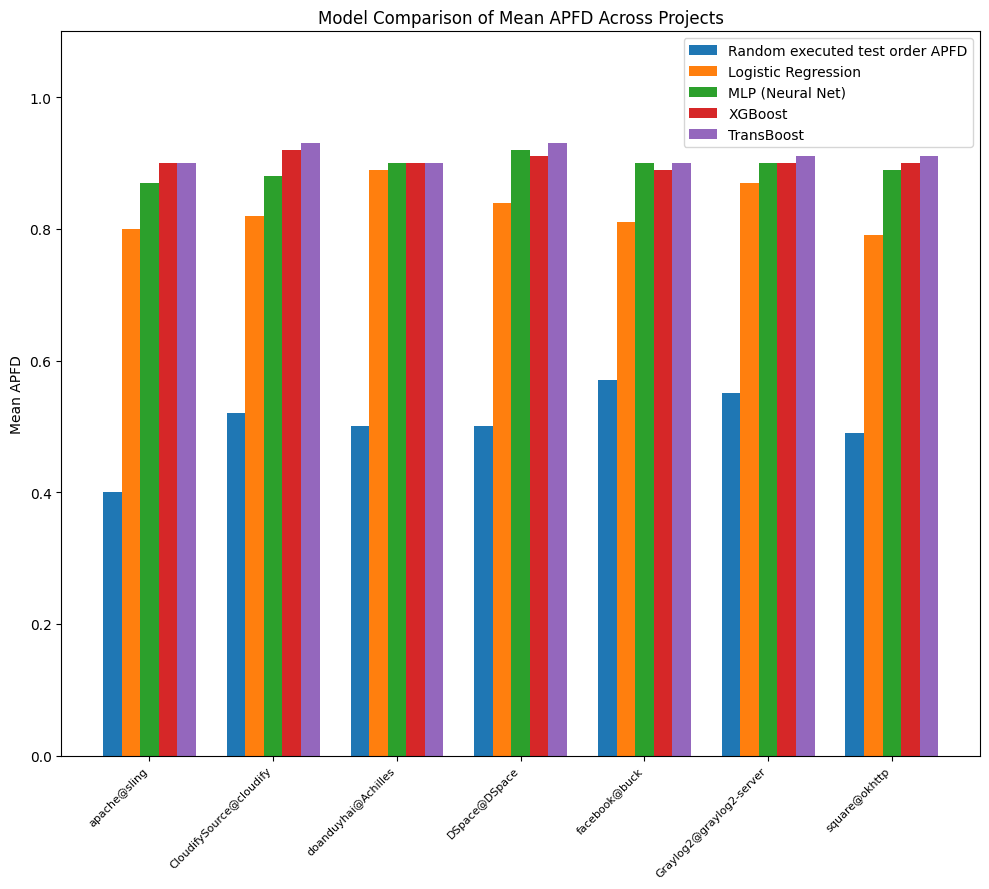

In [56]:
#read from file and plot the results
unordered_apfd_dict = {}
with open('UnorderedAPFD.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(': ')
        unordered_apfd_dict[key] = float(value)

linear_classifier_apfd_dict = {}
with open('LinearClassifier_APFD.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(': ')
        linear_classifier_apfd_dict[key] = float(value)

mlp_classifier_apfd_dict = {}
with open('MLPClassifier_APFD.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(': ')
        mlp_classifier_apfd_dict[key] = float(value)

xg_boost_apfd_dict = {}
with open('XGBoost_mean_APFD.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(': ')
        xg_boost_apfd_dict[key] = float(value)

transboost_apfd_dict = {}
with open('TransBoost_mean_APFD.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(': ')
        transboost_apfd_dict[key] = float(value)

# Plotting the results
projects = list(unordered_apfd_dict.keys())
unordered_apfd_values = list(unordered_apfd_dict.values())
linear_classifier_apfd_values = list(linear_classifier_apfd_dict.values())
mlp_classifier_apfd_values = list(mlp_classifier_apfd_dict.values())
xg_boost_apfd_values = list(xg_boost_apfd_dict.values())
transboost_apfd_values = list(transboost_apfd_dict.values())
x = np.arange(len(projects))  # the label locations
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 9))
ax.bar(x - 2*width, unordered_apfd_values, width, label='Random executed test order APFD')
ax.bar(x - width, linear_classifier_apfd_values, width, label='Logistic Regression')
ax.bar(x, mlp_classifier_apfd_values, width, label='MLP (Neural Net)')
ax.bar(x + width, xg_boost_apfd_values, width, label='XGBoost')
ax.bar(x + 2*width, transboost_apfd_values, width, label='TransBoost')


plt.xticks(rotation=45, ha='right',fontsize=8)
# Labels and titles
ax.set_ylabel('Mean APFD')
ax.set_title('Model Comparison of Mean APFD Across Projects')
ax.set_xticks(x)
ax.set_xticklabels(projects)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

